# Stratus LLA Fun
Python Pointing Sim - Doesn't work
Copyright (C) 2020  Ross Smyth

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.


In [27]:
import numpy as np 
import json
from random import random
from matplotlib import pyplot as plt
%matplotlib notebook

In [2]:
#Stratus's inertia tensor as of 3/25/2018

inertia = np.matrix([[ 40043955.91, 1370933.96,  -1360966.19],
                     [ 1370933.96,  35723448.81, -5385355],
                     [-1332280.32, -5385355.29,   10515755.24]])
inertia *= (1 / 1000)**3

In [3]:
#Finds the maximum rotation that Stratus's reaction wheels can handle

max_rotation = np.amin(np.linalg.solve(inertia, np.array([3.4e-3, 3.4e-3, 3.4e-3])))

In [4]:
total_time = 11000 #total seconds
dt         = .01   #time delta seconds
time       = np.arange(0, total_time+dt, dt) #Time array for plotting

In [5]:
#Gets position data from files that were calculated using MATLAB
    
with open('pastPositions.json') as positions: #rip
    positions = json.load(positions)
    positions = np.asarray(positions).transpose()

In [6]:
def max_rot_vel():
    """angles - Calculates the maximum angular velocity between each location when LLA pointing
    
        Outputs:
            max_omega [float] = The largest magnitude of rotational velocity needed to continue poiting
            Also plots omega vs time
    """
    
    #Generate a random target coordinate by rotating the cloud height position vector around the earth
    target         = np.array([(6371 + 12.5) * 1000, 0, 0])
    
    random_x       = np.random.rand(1) * 2 * np.pi
    rotater_x      = np.matrix(f'1, 0, 0; 0, {np.cos(random_x)}, -{np.sin(random_x)}; 0, {np.sin(random_x)}, {np.cos(random_x)} ')
    
    random_y       = np.random.rand(1) * 2 * np.pi
    rotater_y      = np.matrix(f'{np.cos(random_y)}, 0, {np.sin(random_y)}; 0, 1, 0; -{np.sin(random_y)}, 0, {np.cos(random_y)}')
    
    random_z       = np.random.rand(1) * 2 * np.pi
    rotater_z      = np.matrix(f'{np.cos(random_y)}, -{np.sin(random_y)}, 0; {np.sin(random_y)}, {np.cos(random_y)}, 0; 0, 0, 1')
    
    target         = rotater_x @ rotater_y @ rotater_z @ target #A bunch of rotation matrices
    
    #Creates the vectors between Stratus's position and the target
    vectors        = np.subtract(target, positions)
    
    #Makes all the vectors unit vectors using 'fancy' math copied from a library the did it except faster
    vectors        = np.divide(vectors, np.sqrt(np.einsum('ij,ij->i', vectors, vectors))[:, np.newaxis])
    
    #Makes a copy, shifts all the indexes towards the end, and replaces the first index with a copy of itself
    vectors_dot    = np.vstack((vectors[1], vectors[0:-1]))
    
    #Finds the dot product between each consecutive column using fancy math
    dotted_vectors = np.einsum('ij,ij->i', vectors, vectors_dot)
    
    #Finds the angle between each vector
    omega          = np.arccos(dotted_vectors)
    omega          = np.divide(omega, dt)
    
    plt.plot(time, omega)
    
    return np.amax(omega)

0.01103249189895136


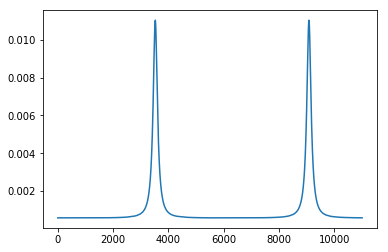

In [7]:
max_angle = max_rot_vel()
print(f"{max_angle}")

<IPython.core.display.Javascript object>


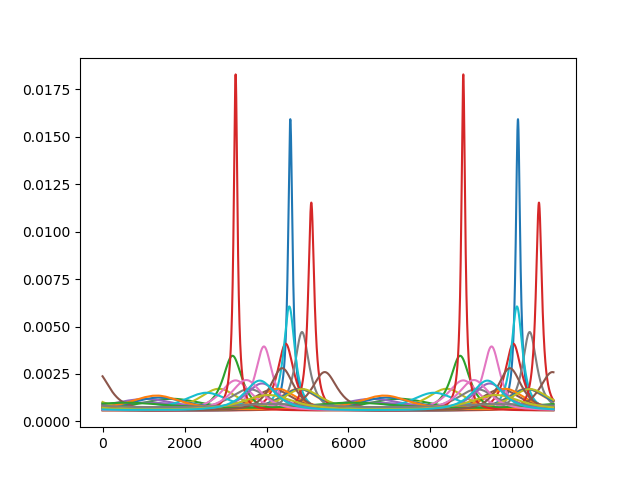

In [30]:
stats = np.load('stats.npy')

for i in range(30):
        stats = np.append(stats, max_rot_vel())
        
stats = stats[~np.isnan(stats)]

np.save('stats.npy', stats)
    
stats = np.divide(stats, max_rotation)

<IPython.core.display.Javascript object>


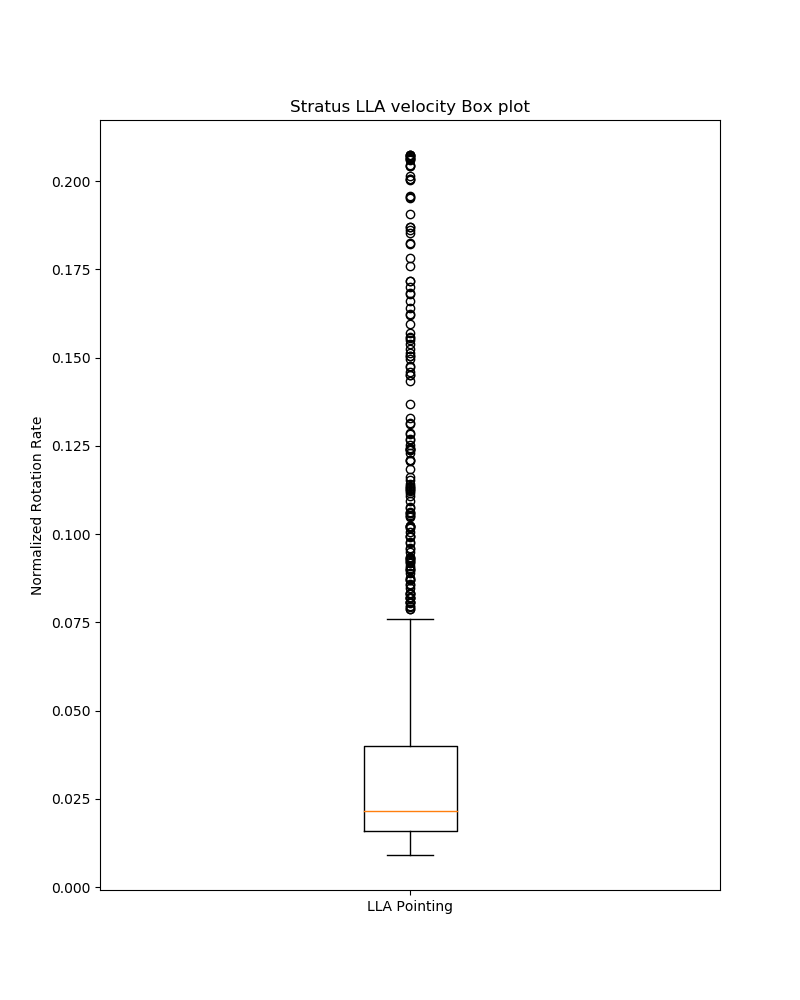

In [32]:
plt.figure(figsize=(8,10))
plt.title('Stratus LLA velocity Box plot')
plt.ylabel('Normalized Rotation Rate')
plt.boxplot(stats, labels=['LLA Pointing'])
plt.show()